# simulation rat behavior

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.integrate import simps
from scipy.interpolate import interp1d

In [2]:
class Rat():
    def __init__(self):

        self.time = 0
        self.dt = 0.04
        self.block_duration = 300
        self.session_length = 3600
        self.position_array = np.zeros(int(self.session_length / self.dt))
        self.test_array = np.zeros(int(self.session_length / self.dt))

        self.high_probability = 0.9
        self.low_probability = 0.1
        

        self.state = "idle"
        self.previous_run = "to_left"
        self.position_Left = 0
        self.position_Right = 100
        self.position = self.position_Left
        self.memory_size = 3
        self.memory_buffer = np.ones(self.memory_size)



        # Average parameters batch 1 for idle time fit
        self.alpha = 1.19
        self.alpha_prime = 0.17
        self.alpha_second = 0.01
        self.gamma = 0.66
        self.gamma_prime = -0.06
        self.gamma_second = -0.12

        # Average parameters batch 1 for running time fit
        self.t0 = 1.37
        self.t0_prime = 0.08
        self.t0_second = -0.02
        self.sigma = 0.09
        self.sigma_prime = 0.01
        self.sigma_second = 0.02


        # RatF00 parameters idle time fit
        # self.alpha = 0.74
        # self.alpha_prime = 0.197
        # self.alpha_second = 0.16
        # self.gamma = 0.44
        # self.gamma_prime = -0.04
        # self.gamma_second = -0.08

        # # RatF00 parameters running time fit
        # self.t0 = 1.37
        # self.t0_prime = 0.09
        # self.t0_second = -0.0
        # self.sigma = 0.11
        # self.sigma_prime = 0.02
        # self.sigma_second = 0.03

        # Initialize parameters
        self.ALPHA = self.alpha 
        self.GAMMA = self.gamma
        self.T0 = self.t0
        self.SIGMA = self.sigma

    def _reward_probability(self):
        if self.time < 0: 
            current_block = 0
        elif self.time < self.session_length: 
            current_block = self.time // self.block_duration
        else: 
            current_block = 11
        
        if current_block % 2 == 0:
            return self.high_probability
        else:
            return self.low_probability
    
    def _reward(self):
        return np.random.choice([1, 0], p=[self._reward_probability(), 1-self._reward_probability()])

    def _update_memory(self, new_reward):
        self.memory_buffer = np.roll(self.memory_buffer, -1)
        self.memory_buffer[-1] = new_reward

    def _round_nearest(self, x, a):
        return np.around(x / a) * a

    def _generate_running_time(self, _loc, _scale, N=1):
        u = np.random.uniform(0, 1, int(N))
        res = np.tan(np.pi * (u - 0.5)) * _scale + _loc
        if res < 0.5: # minimum running time is 0. seconds
            res = self._generate_running_time(_loc, _scale, N=1)
        return self._round_nearest(res, self.dt)

    def _generate_idle_time(self, alpha, gamma, N=1, maximum=500):
        def p(x, a, g): 
            return a / np.sqrt(2 * np.pi * x ** 3) * np.exp(-((a-g * x) ** 2) / (2 * x))
        def normalization(x, a, g): 
            return simps(p(x, a, g), x)
        x = np.linspace(1e-8, maximum, maximum*100)

        pdf = p(x, alpha, gamma)/normalization(x, alpha, gamma)
        cdf = np.cumsum(pdf); cdf /= max(cdf)
        u = np.random.uniform(0, 1, int(N))
        interp_function = interp1d(cdf, x)
        samples = interp_function(u)
        return self._round_nearest(samples, self.dt)
    
    def _update_p(self, parameter, parameter_prime, parameter_second):
        # parameter_prime is the slope of the parameter on the time axis (time bin 10 min), 
        # so we divide by 10*60 to get the slope per time unit
        parameter_prime /= (10*60)
        parameter_prime *= self.time

        # parameter_second is the slope of the parameter on the reward axis (reward bins 1, 0.67, .33, 0 if memory size is 3),
        # we add one parameter_second for each reward bin going from 1 to 0
        memory_average = round(np.mean(self.memory_buffer), 2)
        coef = {1:0, 0.67:1, 0.33:2, 0:3}
        parameter_second *= coef[memory_average]

        return parameter + parameter_prime + parameter_second

    def update_parameters(self):
        self.ALPHA = self._update_p(self.alpha, self.alpha_prime, self.alpha_second)
        self.GAMMA = self._update_p(self.gamma, self.gamma_prime, self.gamma_second)
        self.T0 = self._update_p(self.t0, self.t0_prime, self.t0_second)
        self.SIGMA = self._update_p(self.sigma, self.sigma_prime, self.sigma_second)

    def wait(self, idle_time):
        start_time = self.time
        while self.time <= start_time + idle_time and self.time <= self.session_length:
            self.position_array[int(self.time / self.dt)] = self.position
            self.state = "idle"
            self.time += self.dt
            self.update_parameters()
        self.state = "running"

    def _position_curve(self, mu=.5, sigma=.2, N=100):
        def _bell_curve(x, mu, sigma):
            return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2) )
        x = np.linspace(0, 1, N+1)
        return np.cumsum(_bell_curve(x, mu, sigma))/N

    def _trajectory(self, start_position, end_position, running_time):
        N = int(running_time / self.dt)
        position = self._position_curve(N=N) * (end_position - start_position) + start_position
        return position

    def run(self, running_time):
        start_time = self.time
        if self.previous_run == "to_left":
            start_position = self.position_Left
            end_position = self.position_Right
        else:
            start_position = self.position_Right
            end_position = self.position_Left

        trajectory = self._trajectory(start_position, end_position, running_time)

        while self.time <= start_time + running_time and self.time <= self.session_length:
            self.position = trajectory[int((self.time - start_time) / self.dt)]
            self.position_array[int(self.time / self.dt)] = self.position
            self.state = "running"
            self.time += self.dt
            self.update_parameters()

        self.position = end_position
        self.state = "idle"
        self._update_memory(self._reward())
        self.previous_run = "to_left" if self.previous_run == "to_right" else "to_right"

    def do_experiment(self):
        while self.time <= self.session_length:
            if self.state == "idle":
                idle_time = self._generate_idle_time(self.ALPHA, self.GAMMA, 1)
                self.wait(idle_time)
            elif self.state == "running":
                running_time = self._generate_running_time(self.T0, self.SIGMA, 1)
                self.run(running_time)

rat = Rat()
rat.do_experiment()

(0.0, 90000.0)

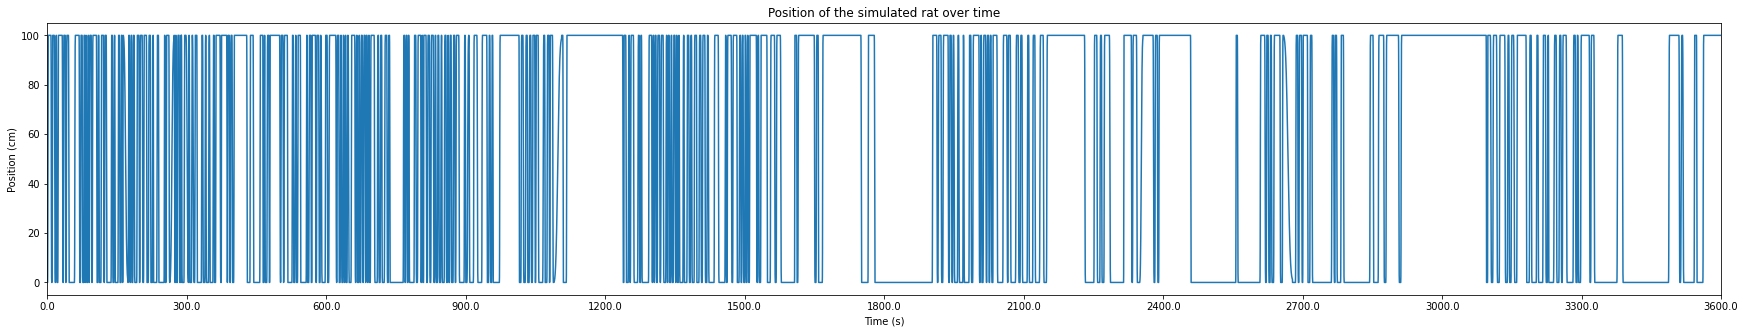

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(30, 5))
ax.plot(rat.position_array)
ax.set_xlabel("Time (s)")
ax.set_xticks(np.arange(0, len(rat.position_array)+7500, 300*25))
ax.set_xticklabels(np.arange(0, len(rat.position_array)+7500, 300*25) * rat.dt)
ax.set_ylabel("Position (cm)")
ax.set_title("Position of the simulated rat over time")
ax.set_ylim(-5, 105)
ax.set_xlim(0, len(rat.position_array))